# Demo: Nonloc heatflux

This notebook provide a demo case on the application of the heat conduction solver.
<br>

## Geometry & Computational Grid
In this case, we will consider a 1d plasma with temperature, electron density, ionization rate and Knudsen number profiles, provided by kinetic simulation with length $L  = 0.19$ cm.  We will use $N=200$ nodes for this profile. As you can see, the grid spacing, $dx$ will be $L/(N-1)=954$ $\mu \mathrm{m}$.

First, import parameter module in order to get a Pandas series containing all the parameters.
Last two rows contain a NN training part. The `io.capture_output` function is used to avoid the overfilling of output (to many messages are displayed and VS Code can't manage that)

In case coefficients $\alpha$ and $\beta$ are defined without using the NN, use `model = None`

In [18]:
import importlib
from IPython.utils import io
import NN_training
importlib.reload(NN_training)
%matplotlib widget
with io.capture_output() as captured:
    model=NN_training.train_model(100) #argument is the number of epochs
    #model=None 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type    | Params
-------------------------------------
0 | fcIn     | Linear  | 2.8 K 
1 | fcOut    | Linear  | 62    
2 | mse_loss | MSELoss | 0     
-------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.011     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.


All parameters of the problem, such as number of used profiles points, boundary conditions, definition of parameters $\alpha$ and $\beta$, number of timesteps and its magnitude $dt$ are contained and may be modified in `parameter.py` file.

`importlib` module and `reload` function in particullar are used to update modules if modified

In [19]:
import importlib
import parameter as param
import heatConduction as hc
importlib.reload(hc)
importlib.reload(param)   #In order to apply changes in the module 
para = param.main(model)

`heatConduction.py` package contains necessary components to solve the PDEs.
It also creates a `matplotlib` figure, which will display heatflux calculated using neural network, (if) trained in first cell.

Next cell initiates solution of the problem. The result temperature profiles, last cache and coefficients are contained in these four variables accordingly

In [20]:
results, cache, alphas, betas, heatflux = hc.solve(para)

 Heat Conduction Solver
 [Step] [Time] [Iter] [Residue] [Newton outcome] [Max beta] [Max alpha] [Minimal T] [Maximal T] [meanEnergy]
[  1 ] [3.90E+02 ] [32 ] [7.28E-13 ] [7.60E-11 ] [2.51E+00 ] [7.96E+00 ] [2.74E+02 ] [2.55E+03 ] [3.26E+16 ]
[  2 ] [7.87E+02 ] [32 ] [1.70E-13 ] [4.00E-11 ] [2.55E+00 ] [7.96E+00 ] [2.74E+02 ] [2.53E+03 ] [3.26E+16 ]
[  3 ] [1.19E+03 ] [32 ] [9.56E-13 ] [3.19E-10 ] [2.59E+00 ] [5.40E+01 ] [2.74E+02 ] [2.51E+03 ] [3.26E+16 ]
[  4 ] [1.61E+03 ] [32 ] [8.81E-12 ] [4.42E-09 ] [2.58E+00 ] [6.31E+02 ] [2.74E+02 ] [2.49E+03 ] [3.26E+16 ]
[  5 ] [2.03E+03 ] [32 ] [1.56E-10 ] [9.51E-08 ] [2.57E+00 ] [1.08E+04 ] [2.74E+02 ] [2.47E+03 ] [3.26E+16 ]
[  6 ] [2.47E+03 ] [32 ] [2.53E-09 ] [1.49E-06 ] [2.57E+00 ] [2.64E+05 ] [2.74E+02 ] [2.45E+03 ] [3.26E+16 ]
[  7 ] [2.90E+03 ] [32 ] [2.81E-09 ] [1.29E-06 ] [2.56E+00 ] [3.32E+05 ] [2.74E+02 ] [2.44E+03 ] [3.26E+16 ]
[  8 ] [3.34E+03 ] [32 ] [2.68E-09 ] [2.90E-07 ] [2.56E+00 ] [4.19E+05 ] [2.74E+02 ] [2.43E+03 ] [3.26E+

The `results` is a numpy array consist of evolution of each time step over the domain. The `cache` file is a Python dictionary consists of some variables used by debugging. <br>
In order to view the results, import the postprocessing package and preprocess the results. <br>
The preprocess transform the numpy array into a Pandas DataFrame, with index as grid locations and columns as timings.

## Visualization of $\alpha$ and $\beta$

In [21]:
import pandas as pd
import postprocessing as pp
importlib.reload(pp)
T = pd.DataFrame(results)
alpha3d=pd.DataFrame(alphas, columns=T.columns,index=T.index)
beta3d=pd.DataFrame(betas, columns=T.columns,index=T.index)
heatflux3d=pd.DataFrame(heatflux, columns=T.columns,index=T.index)

## Visualization of temperature profiles
The first plot is the evolution field in both time and space. We can view the results in a 3D contour plot by just passing the processed T to the function evolutionField(). <br>
It can be seen that the temperature over the var is increasing as time elapses.

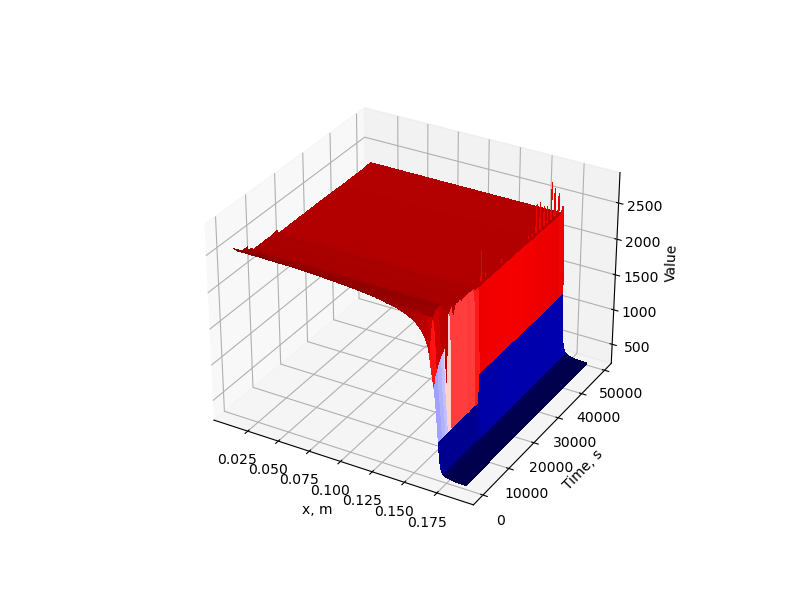

In [22]:
pp.evolutionField(T)

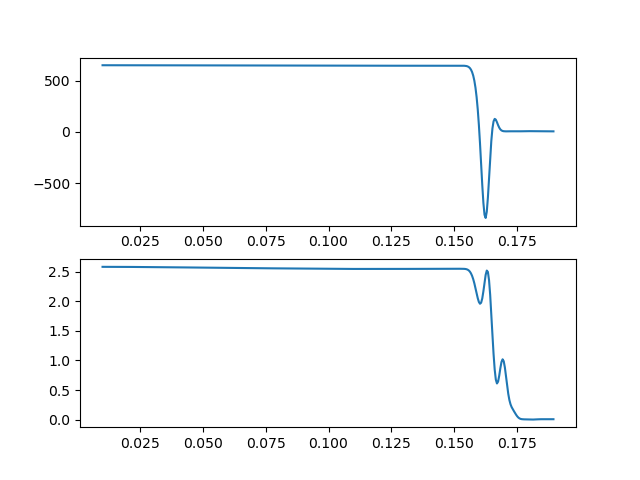

In [23]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(2,1)
ax[0].plot( alpha3d.index, alpha3d[alpha3d.columns[-13]])
ax[1].plot( alpha3d.index, beta3d[alpha3d.columns[-13]])

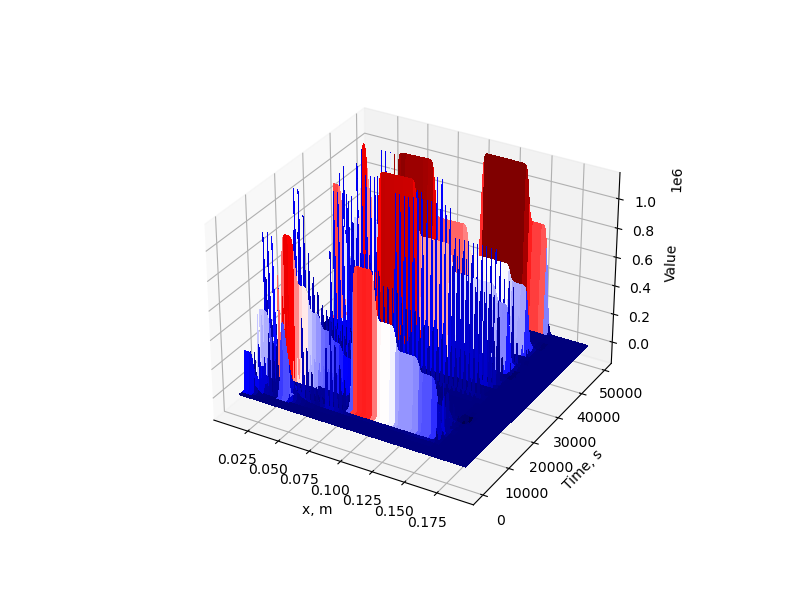

In [24]:
pp.evolutionField(alpha3d)

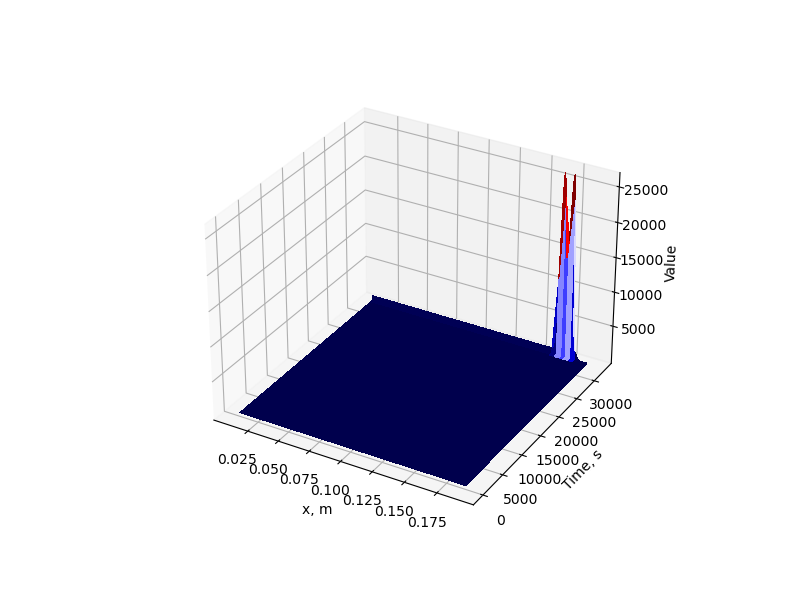

In [8]:
pp.evolutionField(beta3d)

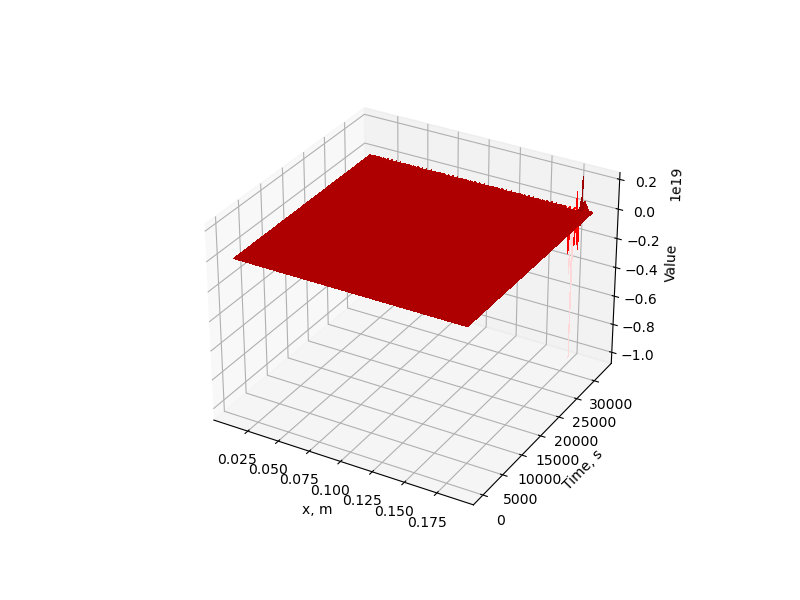

In [9]:
pp.evolutionField(heatflux3d)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
init_profile=pd.read_csv('./Data/init_profile.csv', index_col=(0)).iloc[::100,:]
data_scaling = pd.read_csv(f'./Data/data_scaling.csv', header=0, index_col=0)
nescaled  = (init_profile['ne']-data_scaling['n'].loc['mean'])/data_scaling['n'].loc['std']
Zscaled = (init_profile['Zbar']-data_scaling['Z'].loc['mean'])/data_scaling['Z'].loc['std']
Knscaled  = (init_profile['Kn']-data_scaling['Kn'].loc['mean'])/data_scaling['Kn'].loc['std']
Z=np.array(init_profile['Zbar'])

calheatdflux = pd.DataFrame()
for col in T.columns:
    calheatdflux[col]=- alpha3d[col]/Z *(Z+0.24)/(Z+4.2) * T[col]**(beta3d[col])*np.gradient(T[col])
pp.evolutionField(calheatdflux)

ValueError: Unable to coerce to Series, length must be 22: given 400

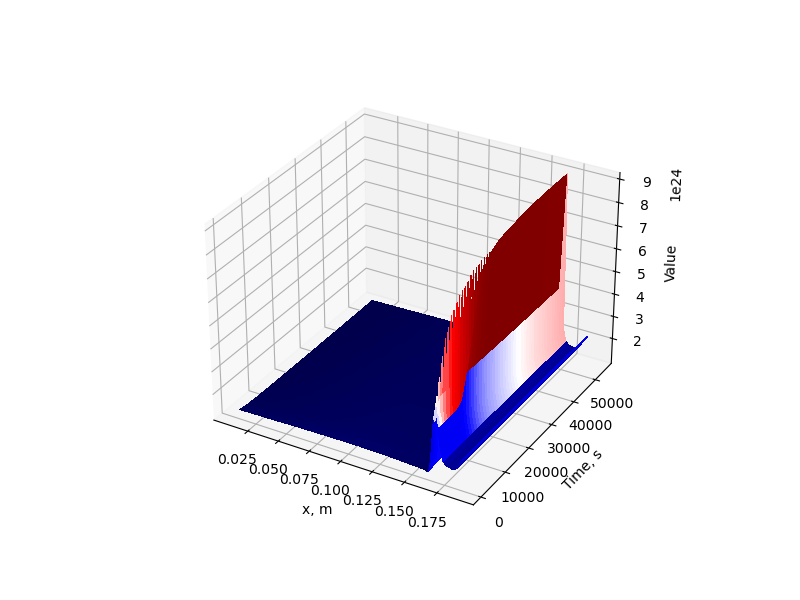

In [ ]:
E=(T.T*init_profile['ne'].values).T
pp.evolutionField(E[E.columns[2:]])

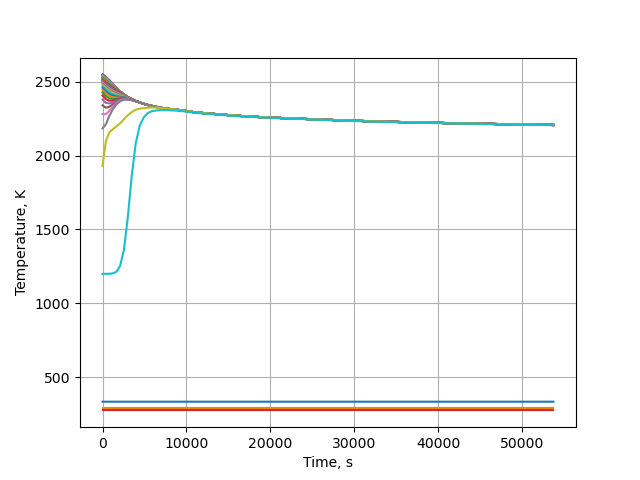

In [ ]:
positions = T.index[::int(len(T)*3e-2)]
pp.thermalCouplePlot(T, positions)

We can futher check how the temperature is distributed over the domain at different times. Simply create a list of timings you want, and pass the T and times to the temperatureDistribution functions.

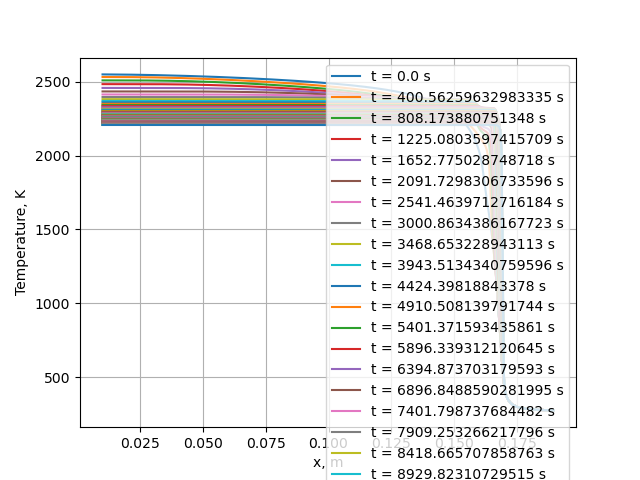

In [ ]:
times = T.columns#[::int(len(T.columns)/100)][1:4]
pp.temperatureDistribution(T, times)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
init_profile=pd.read_csv('./Data/init_profile.csv', index_col=(0)).iloc[::100,:]
data_scaling = pd.read_csv(f'./Data/data_scaling.csv', header=0, index_col=0)
nescaled  = (init_profile['ne']-data_scaling['n'].loc['mean'])/data_scaling['n'].loc['std']
Zscaled = (init_profile['Zbar']-data_scaling['Z'].loc['mean'])/data_scaling['Z'].loc['std']
Knscaled  = (init_profile['Kn']-data_scaling['Kn'].loc['mean'])/data_scaling['Kn'].loc['std']
Tscaled  = (init_profile['Te']-data_scaling['T'].loc['mean'])/data_scaling['T'].loc['std']
gradTscaled  = (init_profile['gradTe']-data_scaling['gradT'].loc['mean'])/data_scaling['gradT'].loc['std'] 
xdsd=np.array(init_profile['x'])

In [ ]:
Tprscaled=pd.DataFrame((results-data_scaling['T'].loc['mean'])/data_scaling['T'].loc['std'], columns=T.columns,index=T.index)
Tgradscaled = pd.DataFrame(np.gradient(results, axis=0), columns=T.columns,index=T.index)

In [ ]:
Tprscaled

,0.000000,400.562596,808.173881,1225.080360,1652.775029,2091.729831,2541.463971,3000.863439,3468.653229,3943.513434,...,48571.054537,49142.461382,49714.225785,50286.354499,50858.840130,51431.683044,52004.878702,52578.427739,53152.326196,53726.576721
x,,,,,,,,,,,,,,,,,,,,,
0.010000,0.527527,0.503002,0.471555,0.436264,0.400735,0.367898,0.339378,0.315293,0.295462,0.278888,...,0.060337,0.059572,0.058792,0.058030,0.057267,0.056514,0.055761,0.055017,0.054267,0.053530
0.010450,0.527465,0.503000,0.471554,0.436264,0.400735,0.367898,0.339378,0.315293,0.295462,0.278888,...,0.060337,0.059572,0.058792,0.058030,0.057267,0.056514,0.055761,0.055017,0.054267,0.053530
0.010900,0.527401,0.502995,0.471553,0.436264,0.400735,0.367898,0.339378,0.315293,0.295462,0.278888,...,0.060337,0.059572,0.058792,0.058030,0.057267,0.056514,0.055761,0.055017,0.054267,0.053530
0.011350,0.527335,0.502988,0.471552,0.436264,0.400735,0.367898,0.339378,0.315293,0.295462,0.278888,...,0.060337,0.059572,0.058792,0.058030,0.057267,0.056514,0.055761,0.055017,0.054267,0.053530
0.011800,0.527266,0.502978,0.471550,0.436263,0.400735,0.367898,0.339378,0.315293,0.295462,0.278888,...,0.060337,0.059572,0.058792,0.058030,0.057267,0.056514,0.055761,0.055017,0.054267,0.053530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.187754,-2.619782,-2.619782,-2.619782,-2.619782,-2.619782,-2.619782,-2.619782,-2.619782,-2.619782,-2.619782,...,-2.619782,-2.619782,-2.619782,-2.619782,-2.619782,-2.619782,-2.619782,-2.619782,-2.619782,-2.619782
0.188204,-2.620097,-2.620097,-2.620097,-2.620097,-2.620097,-2.620097,-2.620097,-2.620097,-2.620097,-2.620097,...,-2.620097,-2.620097,-2.620097,-2.620097,-2.620097,-2.620097,-2.620097,-2.620097,-2.620097,-2.620097
0.188654,-2.620374,-2.620374,-2.620374,-2.620374,-2.620374,-2.620374,-2.620374,-2.620374,-2.620374,-2.620374,...,-2.620374,-2.620374,-2.620374,-2.620374,-2.620374,-2.620374,-2.620374,-2.620374,-2.620374,-2.620374


In [ ]:
alphaprof=pd.DataFrame()
betaprof=pd.DataFrame()
heatprof=pd.DataFrame()
for i in T.columns:
    alphatest, betatest, heatfluxtest = hc.get_data_qless(model, xdsd,Tprscaled[i], Tgradscaled[i], Zscaled, nescaled, Knscaled, 67 )
    alphaprof[i]=alphatest
    betaprof[i]=betatest
    heatprof[i]=heatfluxtest

RuntimeError: mat1 and mat2 shapes cannot be multiplied (334x268 and 92x30)

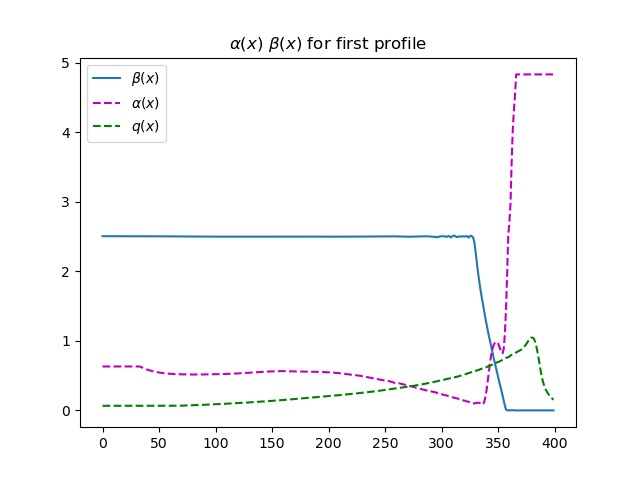

In [ ]:
al, be, he = hc.get_data_qless(model, xdsd,Tscaled, gradTscaled, Zscaled, nescaled, Knscaled, 67 )

fi, ax = plt.subplots()
ax.plot(be, label=r'$\beta(x)$')
ax.plot(al, 'm--', label=r'$\alpha(x)$')
ax.plot(he/1e14, 'g--', label=r'$q(x)$')
ax.set_title(r'$\alpha(x)$ $\beta(x)$ for first profile')
ax.legend(loc='best')

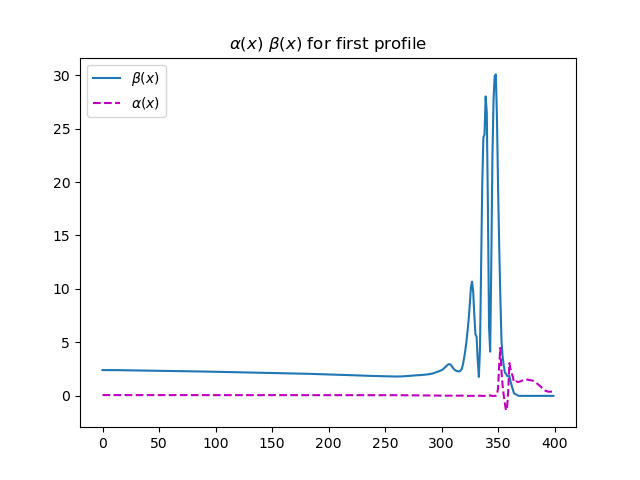

In [ ]:

fi2, ax2 = plt.subplots()
ax2.plot(betaprof[[T.columns[4]]], label=r'$\beta(x)$')
ax2.plot(alphaprof[T.columns[4]], 'm--', label=r'$\alpha(x)$')
ax2.set_title(r'$\alpha(x)$ $\beta(x)$ for first profile')
ax2.legend(loc='best')

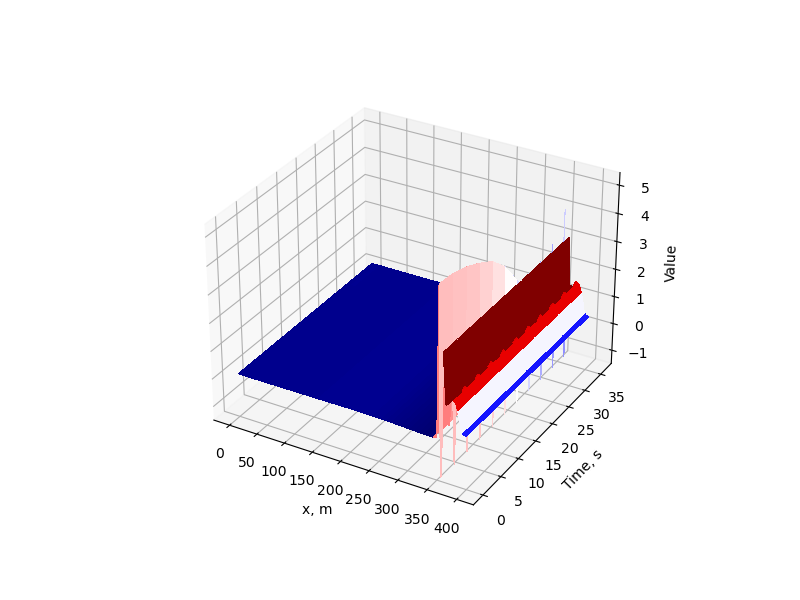

In [ ]:
pp.evolutionField(alphaprof)

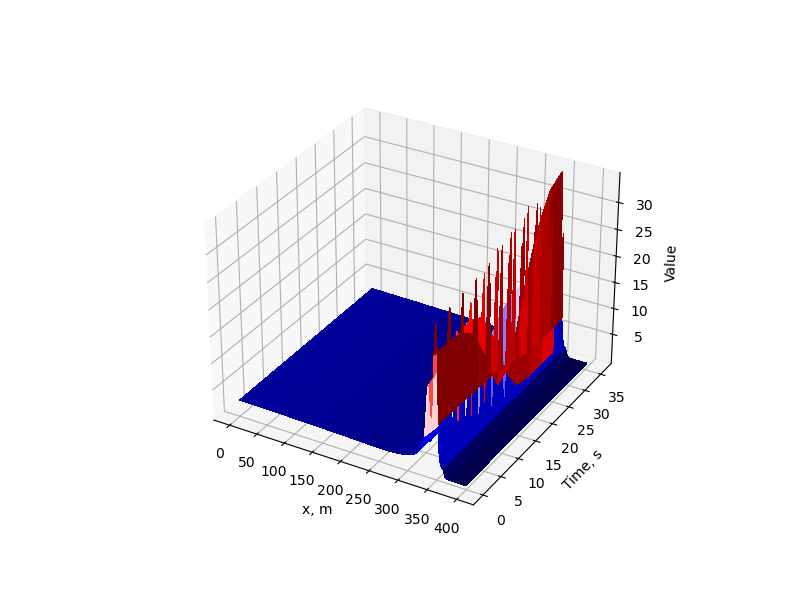

In [ ]:
pp.evolutionField(betaprof)

This notebook and the whole structure of the modules solving the time evolution of temperature distribution are based on github heatConduction repository published by https://github.com/rickfu415